In [1]:
# calculate elapsed time
import time
start_time = time.time()

#### IMPORT

In [2]:
import os, platform
import py7zr

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [3]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
N_FEATURES = 220
TIMESTEPS = 1
EPOCH=400
BATCH_SIZE=10

SPLIT_RATIO=0.2

###############
# # preview # #
###############
f = False
t = True

# checking dataset
CHECK_BLANKS = True
CHECK_CLASS_IMBALANCE = True

# evaluate suitable kfold number and kfold model
MIN_KFOLD = 2
MAX_KFOLD = 11
N_KFOLD = 5
EVAL_KFOLD_NUM = False
EVAL_KFOLD_MODEL = False
PERFORM_KFOLD = True

# model testing
TEST_MODEL = True
CON_MATRIX = True
ROC_GRAPH = True

###############
# # dataset # #
###############
CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 2

DATASET_DIR_NAME = "dataset\set04\\01_own"
SAMPLE_DATASET_NAME = "own_train"
ACTUAL_DATASET_NAME = "own_test"

MODEL_DIR_NAME = "dataset\set04\\01_own"
MODEL_NAME = "model_" + "set04_01_own"

RESULT_DIR_NAME = "dataset\set04\\01_own"
RESULT_NAME = "result_" + "set04_01_own"

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
SAMPLE_DATASET_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".csv")
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME + ".h5")

RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

In [4]:
if os.path.isdir(DATASET_DIR_PATH) is True:
    print(f"Dataset directory exists at: {DATASET_DIR_PATH}")
else:
    try:
        os.mkdir(DATASET_DIR_PATH, 666)
        print(f"Dataset directory have been created at: {DATASET_DIR_PATH}")
    except:
        print("Error: Dataset Directory not created")
        
if os.path.isdir(MODEL_DIR_PATH) is True:
    print(f"Model directory exists at: {MODEL_DIR_PATH}")
else:
    try:
        os.mkdir(MODEL_DIR_PATH, 666)
        print(f"Model directory have been created at: {MODEL_DIR_PATH}")
    except:
        print("Error: Model Directory not created")
    
if os.path.exists(SAMPLE_DATASET_PATH) is True:
    print(f"Training dataset exists at: {SAMPLE_DATASET_PATH}")
else:
    try:
        SAMPLE_7Z_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".7z")
        with py7zr.SevenZipFile(SAMPLE_7Z_PATH, mode='r') as z:
            z.extractall(path=DATASET_DIR_PATH)
        print(f"Decompress 7z file to: {SAMPLE_7Z_PATH}")
    except:
        print("Error: Failed to decompress 7z file.")

Dataset directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set04\01_own
Model directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set04\01_own
Training dataset exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set04\01_own\own_train.csv


#### CREATE MODEL
- Create base model
- Wrap it with KerasClassifier

In [5]:
#create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True,
             input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.2))

    # softmax for multi-class classification
    model.add(Flatten())
    print("There are a total of " + str(n_classes) + " classes.")
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=EPOCH, 
                            batch_size=BATCH_SIZE)
    return model

In [6]:
# divide data into features X and target (classes) Y
def prepare_dataset(df):
    X = df.values[:,FEATURES_COL_NUM:].astype(float)
    Y = df.values[:,CLASSES_COL_NUM].astype(str)

    # convert target Y to labelbinarizer Y for model
    # fit_transform is not used to reuse lb
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)

    #################################
    # # get all the encoded class # #
    #################################
    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    ###########################
    # # print X and Y shape # #
    ###########################
    print(f"X | Features | Dataset Shape: {X.shape}")
    print(f"Y | Classes  | Dataset Shape: {Y.shape}")

    return X, Y, lb, lb.classes_.tolist()

In [7]:
def split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED):

    ##############################################################
    # # split dataset into train and test set of 0.8/0.2 ratio # #
    ##############################################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=SPLIT_RATIO, random_state=SEED)

    ############################
    # # reshaping of dataset # #
    ############################

    # reshaping the dataset to include LSTM Timesteps
    print(X_train.dtype)
    X_train = np.asarray(X_train, dtype=np.float32)
    print(X_train.dtype)
    X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
    print(X_test.dtype)
    X_test = np.asarray(X_test, dtype=np.float32)
    print(X_test.dtype)
    X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

    print(f"X train shape: {X_train.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"X test shape: {X_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

def reshape_dataset(X, TIMESTEPS):
    # reshaping the dataset to include LSTM Timesteps
    X = np.asarray(X, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))
    return X

#### LOAD DATASET

In [8]:
# load dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)
df.head()

,Subject,Password,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T7-RF|VAR,T7-NG|VAR,T7-I|SD,T7-PF|SD,T7-RF|SD,T7-NG|SD,T8-I|0+7,T8-PF|0+7,T8-RF|0+7,T8-NG|0+7
0,andy,Co5mical,0.124989,0.000000,0.124989,0.123640,0.248628,0.123640,0.011015,0.134655,...,0.005318,0.005458,0.055285,0.056239,0.072921,0.073875,0.606169,0.731157,0.718543,0.843531
1,andy,Co5mical,0.101935,0.011014,0.112950,0.133594,0.235529,0.122580,0.046207,0.168787,...,0.006047,0.003990,0.047034,0.032436,0.077762,0.063164,0.616391,0.718327,0.697449,0.799384
2,andy,Co5mical,0.090341,-0.012504,0.077837,0.090850,0.181191,0.103354,0.054714,0.158068,...,0.003187,0.002233,0.024718,0.015517,0.056457,0.047256,0.550968,0.641309,0.628636,0.718976
3,andy,Co5mical,0.102711,0.011565,0.114277,0.110634,0.213346,0.099069,0.033884,0.132953,...,0.004878,0.005244,0.046083,0.048659,0.069841,0.072416,0.562252,0.664963,0.652923,0.755634
4,andy,Co5mical,0.127922,0.063317,0.191239,0.188074,0.315996,0.124757,0.023144,0.147900,...,0.016760,0.017344,0.101889,0.104127,0.129459,0.131697,0.638064,0.765986,0.722751,0.850673


#### CHECK DATASET

Checking for blanks...
No blank value has been found.
Checking for class imbalance...


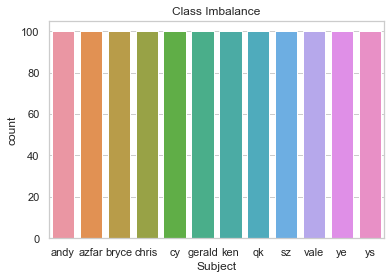

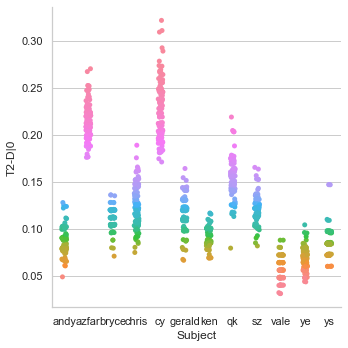

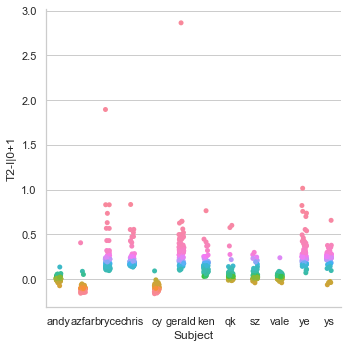

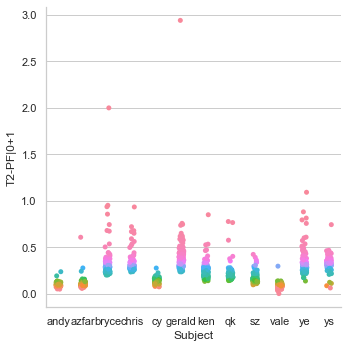

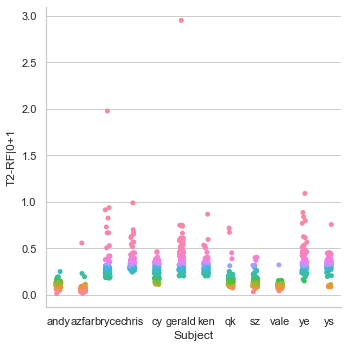

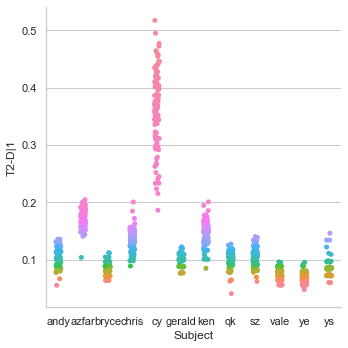

In [9]:
########################
# # check for blanks # #
########################
if CHECK_BLANKS is True:
    # checking for blanks
    print("Checking for blanks...")
    if df.isnull().values.any() is True:
        df = df.dropna(axis=0, how="any")
        print("Blank rows has been dropped.")
    else:
        print("No blank value has been found.")
        
#################################
# # check for class imbalance # #
#################################
if CHECK_CLASS_IMBALANCE is True:
    print("Checking for class imbalance...")
    sns.countplot(x=CLASSES_COL_NAME, data=df).set_title("Class Imbalance")
#     df.loc[(df!=0).any(axis=1)]
    plt.show()

sns.catplot(x="Subject", y="T2-D|0", hue="T2-D|0", data=df, legend=False)
sns.catplot(x="Subject", y="T2-I|0+1", hue="T2-I|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-PF|0+1", hue="T2-PF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-RF|0+1", hue="T2-RF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-D|1", hue="T2-D|1", data=df, legend=False)

#### PREPARE DATASET
- Split data based on X / Features and Y / Classes
- Binarize Y into binary labels

In [10]:
X, Y, lb, class_list = prepare_dataset(df)
n_classes = len(class_list)
print(f"Number of Classes: {n_classes}")

LabelBinarizer is able to decipher: 
['andy' 'azfar' 'bryce' 'chris' 'cy' 'gerald' 'ken' 'qk' 'sz' 'vale' 'ye'
 'ys']


X | Features | Dataset Shape: (1200, 220)
Y | Classes  | Dataset Shape: (1200, 12)
Number of Classes: 12


#### SPLIT DATASET
- Split dataset into train set and test set 0.8 / 0.2

In [11]:
##############################################################
# # split dataset into train and test set of 0.8/0.2 ratio # #
##############################################################
X_train, X_test, y_train, y_test = split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED)

float64
float32
float64
float32
X train shape: (960, 1, 220)
Y train shape: (960, 12)
X test shape: (240, 1, 220)
Y test shape: (240, 12)


#### PERFORM VALIDATION (w KFold Validation)
- Evaluate best KFold Validation
- Generate loss and accuracy graph
- Perform KFold validation

##### Evaluate suitable folds for kfold validation

In [12]:
###############################################
# # evaluate suitable kfold value for model # #
###############################################
def evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD):
    
    # evaluate the model    
    folds = range(MIN_KFOLD, MAX_KFOLD)
    means, mins, maxs = list(), list(), list()
    
    # evaluate each k value
    for k in folds:
        # define the test condition
        kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
        
        # evaluate k value
        model = create_model()
        scores = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)
        
        k_mean = np.mean(scores)
        k_min = scores.min()
        k_max = scores.max()
        
        # report performance
        print(f"No. of Folds: {k} | Accuracy: {k_mean*100:.3f} | Min: {k_min*100:.3f} | Max: {k_max*100:.3f}")
        
        # store mean accuracy and min and max relative to the mean
        means.append(k_mean)
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    # line plot of k mean values with min/max error bars
    clear_output(wait=True)
    pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    
    # show the plot
    pyplot.show()
    
if EVAL_KFOLD_NUM is True:
    evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD)
else:
    print("EVAL_KFOLD_NUM is not True")

EVAL_KFOLD_NUM is not True


##### Generate kfold validation accuracy and loss

In [13]:
##################################################
# # evaluate kfold model for accuracy and loss # #
##################################################
def evaluate_kfold_model(X_train, y_train, SEED):
    scores, histories = list(), list()
    # create model
    model = create_model()
    # prepare cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=50, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        y_pred = model.predict(testX)
        y_pred = to_categorical(y_pred)

        # evaluate predictions
        acc = accuracy_score(testY, y_pred)
        print("Testing accuracy: %.3f%%" % (acc*100))

        # stores scores and histories
        scores.append(acc)
        histories.append(history)

    for i in range(len(histories)):
        # plot loss
        f1 = plt.figure(1)
        plt.title('Categorical Cross-Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        # plot accuracy
        f2 = plt.figure(2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

    # print summary
    print(f"Accuracy | Mean: {np.mean(scores)*100:.3f} | Std: {np.std(scores)*100:.3f} | Length/no.: {len(scores)}")
    # box and whisker plots of results
    f3 = plt.figure(3)
    plt.title('Box and Whisker Plot of Accuracy Scores')
    plt.ylabel('accuracy')
    plt.xlabel('model')
    plt.boxplot(scores)
    clear_output(wait=True)
    plt.show()
    
if EVAL_KFOLD_MODEL is True:
    evaluate_kfold_model(X_train, y_train, SEED)
else:
    print("EVAL_KFOLD_MODEL is not true")

EVAL_KFOLD_MODEL is not true


##### Perform Actual KFold validation

In [14]:
if PERFORM_KFOLD is True:
    # create model
    model = create_model()
    kfold = KFold(n_splits=N_KFOLD, shuffle=True, random_state=SEED)
    valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)
else:
    print("PERFORM_KFOLD is not true.")

There are a total of 12 classes.
Epoch 1/400
77/77 [==============================] - 7s 10ms/step - loss: 2.6319 - accuracy: 0.0768
Epoch 2/400
77/77 [==============================] - 1s 11ms/step - loss: 2.5340 - accuracy: 0.0885
Epoch 3/400
77/77 [==============================] - 1s 11ms/step - loss: 2.4384 - accuracy: 0.1471
Epoch 4/400
77/77 [==============================] - 1s 11ms/step - loss: 2.3374 - accuracy: 0.1628
Epoch 5/400
77/77 [==============================] - 1s 10ms/step - loss: 2.2277 - accuracy: 0.1927
Epoch 6/400
77/77 [==============================] - 1s 10ms/step - loss: 2.1548 - accuracy: 0.2057
Epoch 7/400
77/77 [==============================] - 1s 10ms/step - loss: 2.0910 - accuracy: 0.2201
Epoch 8/400
77/77 [==============================] - 1s 10ms/step - loss: 2.0257 - accuracy: 0.2344
Epoch 9/400
77/77 [==============================] - 1s 10ms/step - loss: 1.9409 - accuracy: 0.2448
Epoch 10/400
77/77 [==============================] - 1s 10ms/step 

77/77 [==============================] - 1s 10ms/step - loss: 1.0288 - accuracy: 0.6380
Epoch 82/400
77/77 [==============================] - 1s 10ms/step - loss: 1.1140 - accuracy: 0.6276
Epoch 83/400
77/77 [==============================] - 1s 9ms/step - loss: 1.0860 - accuracy: 0.6250
Epoch 84/400
77/77 [==============================] - 1s 9ms/step - loss: 1.0545 - accuracy: 0.6263
Epoch 85/400
77/77 [==============================] - 1s 9ms/step - loss: 1.0870 - accuracy: 0.6120
Epoch 86/400
77/77 [==============================] - 1s 9ms/step - loss: 1.0634 - accuracy: 0.6523
Epoch 87/400
77/77 [==============================] - 1s 9ms/step - loss: 1.1176 - accuracy: 0.6393
Epoch 88/400
77/77 [==============================] - 1s 10ms/step - loss: 0.9619 - accuracy: 0.6732
Epoch 89/400
77/77 [==============================] - 1s 10ms/step - loss: 0.9511 - accuracy: 0.6341
Epoch 90/400
77/77 [==============================] - 1s 9ms/step - loss: 1.0422 - accuracy: 0.6107
Epoch 91/

77/77 [==============================] - 1s 9ms/step - loss: 0.7004 - accuracy: 0.7695
Epoch 163/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6714 - accuracy: 0.8164
Epoch 164/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5932 - accuracy: 0.8177
Epoch 165/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7149 - accuracy: 0.7812
Epoch 166/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8674 - accuracy: 0.7292
Epoch 167/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7097 - accuracy: 0.7643
Epoch 168/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7709 - accuracy: 0.7643
Epoch 169/400
77/77 [==============================] - 1s 9ms/step - loss: 0.8794 - accuracy: 0.7383
Epoch 170/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6923 - accuracy: 0.7943
Epoch 171/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6302 - accuracy: 0.7982
Epo

77/77 [==============================] - 1s 9ms/step - loss: 0.4758 - accuracy: 0.8711
Epoch 244/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5281 - accuracy: 0.8516
Epoch 245/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5473 - accuracy: 0.8568
Epoch 246/400
77/77 [==============================] - 1s 11ms/step - loss: 0.5311 - accuracy: 0.8529
Epoch 247/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5326 - accuracy: 0.8711
Epoch 248/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6506 - accuracy: 0.8424
Epoch 249/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5057 - accuracy: 0.8620
Epoch 250/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4803 - accuracy: 0.8646
Epoch 251/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4740 - accuracy: 0.8698
Epoch 252/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4692 - accuracy: 0.8737
E

77/77 [==============================] - 1s 9ms/step - loss: 0.3686 - accuracy: 0.8997
Epoch 325/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5420 - accuracy: 0.8438
Epoch 326/400
77/77 [==============================] - 1s 9ms/step - loss: 0.3806 - accuracy: 0.9010
Epoch 327/400
77/77 [==============================] - 1s 9ms/step - loss: 0.3969 - accuracy: 0.8945
Epoch 328/400
77/77 [==============================] - 1s 10ms/step - loss: 0.4292 - accuracy: 0.8854
Epoch 329/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4143 - accuracy: 0.8932
Epoch 330/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4389 - accuracy: 0.8932
Epoch 331/400
77/77 [==============================] - 1s 10ms/step - loss: 0.3448 - accuracy: 0.9062
Epoch 332/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4964 - accuracy: 0.8607
Epoch 333/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4247 - accuracy: 0.8945
Ep

77/77 [==============================] - 1s 10ms/step - loss: 2.4175 - accuracy: 0.1406
Epoch 4/400
77/77 [==============================] - 1s 10ms/step - loss: 2.2215 - accuracy: 0.1875
Epoch 5/400
77/77 [==============================] - 1s 10ms/step - loss: 2.1323 - accuracy: 0.2057
Epoch 6/400
77/77 [==============================] - 1s 9ms/step - loss: 2.0831 - accuracy: 0.2188
Epoch 7/400
77/77 [==============================] - 1s 9ms/step - loss: 1.9816 - accuracy: 0.2500
Epoch 8/400
77/77 [==============================] - 1s 9ms/step - loss: 1.9816 - accuracy: 0.2331
Epoch 9/400
77/77 [==============================] - 1s 9ms/step - loss: 1.9243 - accuracy: 0.2161
Epoch 10/400
77/77 [==============================] - 1s 10ms/step - loss: 1.9157 - accuracy: 0.2643
Epoch 11/400
77/77 [==============================] - 1s 9ms/step - loss: 1.8523 - accuracy: 0.2695
Epoch 12/400
77/77 [==============================] - 1s 11ms/step - loss: 1.8652 - accuracy: 0.2487
Epoch 13/400
7

77/77 [==============================] - 1s 11ms/step - loss: 1.1956 - accuracy: 0.5104
Epoch 85/400
77/77 [==============================] - 1s 11ms/step - loss: 1.2099 - accuracy: 0.5260
Epoch 86/400
77/77 [==============================] - 1s 11ms/step - loss: 1.1366 - accuracy: 0.5273
Epoch 87/400
77/77 [==============================] - 1s 11ms/step - loss: 1.1638 - accuracy: 0.4974
Epoch 88/400
77/77 [==============================] - 1s 11ms/step - loss: 1.1843 - accuracy: 0.5404
Epoch 89/400
77/77 [==============================] - 1s 11ms/step - loss: 1.0931 - accuracy: 0.5807
Epoch 90/400
77/77 [==============================] - 1s 11ms/step - loss: 1.1675 - accuracy: 0.5234
Epoch 91/400
77/77 [==============================] - 1s 11ms/step - loss: 1.1778 - accuracy: 0.5365
Epoch 92/400
77/77 [==============================] - 1s 11ms/step - loss: 1.2169 - accuracy: 0.5286
Epoch 93/400
77/77 [==============================] - 1s 13ms/step - loss: 1.1135 - accuracy: 0.5417
Epo

77/77 [==============================] - 1s 10ms/step - loss: 0.7947 - accuracy: 0.6901
Epoch 165/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8346 - accuracy: 0.6784
Epoch 166/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8254 - accuracy: 0.6797
Epoch 167/400
77/77 [==============================] - 1s 12ms/step - loss: 0.8338 - accuracy: 0.6836
Epoch 168/400
77/77 [==============================] - 1s 11ms/step - loss: 0.8402 - accuracy: 0.6510
Epoch 169/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8922 - accuracy: 0.6341
Epoch 170/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7746 - accuracy: 0.7188
Epoch 171/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8186 - accuracy: 0.6758
Epoch 172/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8459 - accuracy: 0.6745
Epoch 173/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8844 - accuracy: 0

77/77 [==============================] - 1s 11ms/step - loss: 0.6028 - accuracy: 0.7682
Epoch 245/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7400 - accuracy: 0.7435
Epoch 246/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6545 - accuracy: 0.7682
Epoch 247/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6708 - accuracy: 0.7474
Epoch 248/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6922 - accuracy: 0.7461
Epoch 249/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7935 - accuracy: 0.7357
Epoch 250/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6858 - accuracy: 0.7630
Epoch 251/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6590 - accuracy: 0.7552
Epoch 252/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7003 - accuracy: 0.7852
Epoch 253/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6293 - accuracy: 0

77/77 [==============================] - 1s 10ms/step - loss: 0.6046 - accuracy: 0.8255
Epoch 325/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5430 - accuracy: 0.8529
Epoch 326/400
77/77 [==============================] - 1s 10ms/step - loss: 0.4925 - accuracy: 0.8516
Epoch 327/400
77/77 [==============================] - 1s 10ms/step - loss: 0.4839 - accuracy: 0.8607
Epoch 328/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4524 - accuracy: 0.8672
Epoch 329/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5600 - accuracy: 0.8346
Epoch 330/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5917 - accuracy: 0.8320
Epoch 331/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5834 - accuracy: 0.8346
Epoch 332/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5814 - accuracy: 0.8477
Epoch 333/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5650 - accuracy: 0.

77/77 [==============================] - 1s 9ms/step - loss: 2.3717 - accuracy: 0.1576
Epoch 4/400
77/77 [==============================] - 1s 9ms/step - loss: 2.2961 - accuracy: 0.1432
Epoch 5/400
77/77 [==============================] - 1s 9ms/step - loss: 2.2043 - accuracy: 0.1875
Epoch 6/400
77/77 [==============================] - 1s 9ms/step - loss: 2.1310 - accuracy: 0.1680
Epoch 7/400
77/77 [==============================] - 1s 9ms/step - loss: 2.0745 - accuracy: 0.1901
Epoch 8/400
77/77 [==============================] - 1s 9ms/step - loss: 2.0573 - accuracy: 0.1862
Epoch 9/400
77/77 [==============================] - 1s 9ms/step - loss: 2.0515 - accuracy: 0.1901
Epoch 10/400
77/77 [==============================] - 1s 9ms/step - loss: 2.0206 - accuracy: 0.1979
Epoch 11/400
77/77 [==============================] - 1s 9ms/step - loss: 1.9685 - accuracy: 0.1966
Epoch 12/400
77/77 [==============================] - 1s 9ms/step - loss: 1.9299 - accuracy: 0.2083
Epoch 13/400
77/77 

77/77 [==============================] - 1s 9ms/step - loss: 1.3508 - accuracy: 0.4531
Epoch 85/400
77/77 [==============================] - 1s 9ms/step - loss: 1.3486 - accuracy: 0.4570
Epoch 86/400
77/77 [==============================] - 1s 9ms/step - loss: 1.3212 - accuracy: 0.4622
Epoch 87/400
77/77 [==============================] - 1s 10ms/step - loss: 1.2570 - accuracy: 0.4570
Epoch 88/400
77/77 [==============================] - 1s 10ms/step - loss: 1.2721 - accuracy: 0.4714
Epoch 89/400
77/77 [==============================] - 1s 10ms/step - loss: 1.3659 - accuracy: 0.4453
Epoch 90/400
77/77 [==============================] - 1s 9ms/step - loss: 1.3175 - accuracy: 0.4466
Epoch 91/400
77/77 [==============================] - 1s 10ms/step - loss: 1.3748 - accuracy: 0.4701
Epoch 92/400
77/77 [==============================] - 1s 10ms/step - loss: 1.3036 - accuracy: 0.4935
Epoch 93/400
77/77 [==============================] - 1s 10ms/step - loss: 1.3362 - accuracy: 0.4648
Epoch 9

77/77 [==============================] - 1s 10ms/step - loss: 0.8490 - accuracy: 0.6979
Epoch 165/400
77/77 [==============================] - 1s 10ms/step - loss: 0.9740 - accuracy: 0.6562
Epoch 166/400
77/77 [==============================] - 1s 10ms/step - loss: 0.9130 - accuracy: 0.6549
Epoch 167/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8934 - accuracy: 0.6953
Epoch 168/400
77/77 [==============================] - 1s 10ms/step - loss: 0.9175 - accuracy: 0.6862
Epoch 169/400
77/77 [==============================] - 1s 10ms/step - loss: 0.9331 - accuracy: 0.6628
Epoch 170/400
77/77 [==============================] - 1s 10ms/step - loss: 0.9211 - accuracy: 0.6654
Epoch 171/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8604 - accuracy: 0.6758
Epoch 172/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8832 - accuracy: 0.7031
Epoch 173/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8623 - accuracy: 0

77/77 [==============================] - 1s 10ms/step - loss: 0.6501 - accuracy: 0.7826
Epoch 245/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7032 - accuracy: 0.7943
Epoch 246/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6438 - accuracy: 0.7969
Epoch 247/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5899 - accuracy: 0.8307
Epoch 248/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6330 - accuracy: 0.8073
Epoch 249/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6349 - accuracy: 0.8034
Epoch 250/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6501 - accuracy: 0.7904
Epoch 251/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6781 - accuracy: 0.8034
Epoch 252/400
77/77 [==============================] - 1s 11ms/step - loss: 0.6777 - accuracy: 0.7826
Epoch 253/400
77/77 [==============================] - 1s 11ms/step - loss: 0.6969 - accuracy: 0

77/77 [==============================] - 1s 11ms/step - loss: 0.5921 - accuracy: 0.8438
Epoch 325/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4464 - accuracy: 0.8633
Epoch 326/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4577 - accuracy: 0.8490
Epoch 327/400
77/77 [==============================] - 1s 11ms/step - loss: 0.5425 - accuracy: 0.8411
Epoch 328/400
77/77 [==============================] - 1s 11ms/step - loss: 0.5092 - accuracy: 0.8372
Epoch 329/400
77/77 [==============================] - 1s 11ms/step - loss: 0.6009 - accuracy: 0.8177
Epoch 330/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4140 - accuracy: 0.8568
Epoch 331/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4258 - accuracy: 0.8555
Epoch 332/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4497 - accuracy: 0.8646
Epoch 333/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4037 - accuracy: 0

77/77 [==============================] - 1s 12ms/step - loss: 2.3878 - accuracy: 0.1224
Epoch 4/400
77/77 [==============================] - 1s 12ms/step - loss: 2.2350 - accuracy: 0.1732
Epoch 5/400
77/77 [==============================] - 1s 12ms/step - loss: 2.1707 - accuracy: 0.1549
Epoch 6/400
77/77 [==============================] - 1s 12ms/step - loss: 2.1283 - accuracy: 0.1445
Epoch 7/400
77/77 [==============================] - 1s 12ms/step - loss: 2.1819 - accuracy: 0.1419
Epoch 8/400
77/77 [==============================] - 1s 12ms/step - loss: 2.0962 - accuracy: 0.1745
Epoch 9/400
77/77 [==============================] - 1s 12ms/step - loss: 2.0425 - accuracy: 0.1706
Epoch 10/400
77/77 [==============================] - 1s 12ms/step - loss: 2.0532 - accuracy: 0.1745
Epoch 11/400
77/77 [==============================] - 1s 12ms/step - loss: 2.0576 - accuracy: 0.1458
Epoch 12/400
77/77 [==============================] - 1s 12ms/step - loss: 2.0191 - accuracy: 0.1719
Epoch 13/

77/77 [==============================] - 1s 11ms/step - loss: 1.3932 - accuracy: 0.4414
Epoch 85/400
77/77 [==============================] - 1s 11ms/step - loss: 1.4457 - accuracy: 0.4141
Epoch 86/400
77/77 [==============================] - 1s 12ms/step - loss: 1.4134 - accuracy: 0.4193
Epoch 87/400
77/77 [==============================] - 1s 11ms/step - loss: 1.3873 - accuracy: 0.4505
Epoch 88/400
77/77 [==============================] - 1s 11ms/step - loss: 1.4161 - accuracy: 0.4245
Epoch 89/400
77/77 [==============================] - 1s 11ms/step - loss: 1.6815 - accuracy: 0.3659
Epoch 90/400
77/77 [==============================] - 1s 12ms/step - loss: 1.5164 - accuracy: 0.3932
Epoch 91/400
77/77 [==============================] - 1s 12ms/step - loss: 1.4549 - accuracy: 0.4245
Epoch 92/400
77/77 [==============================] - 1s 12ms/step - loss: 1.5696 - accuracy: 0.3750
Epoch 93/400
77/77 [==============================] - 1s 12ms/step - loss: 1.5187 - accuracy: 0.4036
Epo

77/77 [==============================] - 1s 11ms/step - loss: 0.9621 - accuracy: 0.6159
Epoch 165/400
77/77 [==============================] - 1s 11ms/step - loss: 0.9681 - accuracy: 0.6042
Epoch 166/400
77/77 [==============================] - 1s 11ms/step - loss: 0.9993 - accuracy: 0.6393
Epoch 167/400
77/77 [==============================] - 1s 11ms/step - loss: 0.9608 - accuracy: 0.6185
Epoch 168/400
77/77 [==============================] - 1s 11ms/step - loss: 1.0053 - accuracy: 0.6003
Epoch 169/400
77/77 [==============================] - 1s 11ms/step - loss: 0.9381 - accuracy: 0.6055
Epoch 170/400
77/77 [==============================] - 1s 11ms/step - loss: 0.9727 - accuracy: 0.6276
Epoch 171/400
77/77 [==============================] - 1s 11ms/step - loss: 0.8949 - accuracy: 0.6380
Epoch 172/400
77/77 [==============================] - 1s 11ms/step - loss: 0.9752 - accuracy: 0.6224
Epoch 173/400
77/77 [==============================] - 1s 11ms/step - loss: 1.0038 - accuracy: 0

77/77 [==============================] - 1s 11ms/step - loss: 0.7638 - accuracy: 0.7253
Epoch 245/400
77/77 [==============================] - 1s 11ms/step - loss: 0.7676 - accuracy: 0.7578
Epoch 246/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7342 - accuracy: 0.7474
Epoch 247/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7391 - accuracy: 0.7474
Epoch 248/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7431 - accuracy: 0.7422
Epoch 249/400
77/77 [==============================] - 1s 10ms/step - loss: 0.9351 - accuracy: 0.6875
Epoch 250/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7790 - accuracy: 0.7435
Epoch 251/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7412 - accuracy: 0.7344
Epoch 252/400
77/77 [==============================] - 1s 11ms/step - loss: 0.7236 - accuracy: 0.7422
Epoch 253/400
77/77 [==============================] - 1s 11ms/step - loss: 0.7160 - accuracy: 0

77/77 [==============================] - 1s 10ms/step - loss: 0.5072 - accuracy: 0.8477
Epoch 325/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6008 - accuracy: 0.8203
Epoch 326/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4861 - accuracy: 0.8555
Epoch 327/400
77/77 [==============================] - 1s 10ms/step - loss: 0.4517 - accuracy: 0.8607
Epoch 328/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6213 - accuracy: 0.8151
Epoch 329/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5578 - accuracy: 0.8464
Epoch 330/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4882 - accuracy: 0.8477
Epoch 331/400
77/77 [==============================] - 1s 11ms/step - loss: 0.5330 - accuracy: 0.8372
Epoch 332/400
77/77 [==============================] - 1s 11ms/step - loss: 0.6134 - accuracy: 0.8190
Epoch 333/400
77/77 [==============================] - 1s 11ms/step - loss: 0.6242 - accuracy: 0

77/77 [==============================] - 1s 10ms/step - loss: 2.4856 - accuracy: 0.1081
Epoch 4/400
77/77 [==============================] - 1s 11ms/step - loss: 2.3211 - accuracy: 0.1875
Epoch 5/400
77/77 [==============================] - 1s 14ms/step - loss: 2.1107 - accuracy: 0.2435
Epoch 6/400
77/77 [==============================] - 1s 13ms/step - loss: 1.9907 - accuracy: 0.2630
Epoch 7/400
77/77 [==============================] - 1s 13ms/step - loss: 1.9690 - accuracy: 0.2565
Epoch 8/400
77/77 [==============================] - 1s 15ms/step - loss: 1.8779 - accuracy: 0.2917
Epoch 9/400
77/77 [==============================] - 1s 14ms/step - loss: 1.8879 - accuracy: 0.2487
Epoch 10/400
77/77 [==============================] - 1s 13ms/step - loss: 1.7901 - accuracy: 0.3021
Epoch 11/400
77/77 [==============================] - 1s 13ms/step - loss: 1.7631 - accuracy: 0.3086
Epoch 12/400
77/77 [==============================] - 1s 13ms/step - loss: 1.7190 - accuracy: 0.2969
Epoch 13/

77/77 [==============================] - 1s 11ms/step - loss: 0.9432 - accuracy: 0.6628
Epoch 85/400
77/77 [==============================] - 1s 11ms/step - loss: 0.8992 - accuracy: 0.6927
Epoch 86/400
77/77 [==============================] - 1s 11ms/step - loss: 0.9318 - accuracy: 0.6693
Epoch 87/400
77/77 [==============================] - 1s 12ms/step - loss: 0.9306 - accuracy: 0.6641
Epoch 88/400
77/77 [==============================] - 1s 12ms/step - loss: 1.0262 - accuracy: 0.6445
Epoch 89/400
77/77 [==============================] - 1s 11ms/step - loss: 1.0391 - accuracy: 0.6602
Epoch 90/400
77/77 [==============================] - 1s 11ms/step - loss: 0.9177 - accuracy: 0.6784
Epoch 91/400
77/77 [==============================] - 1s 11ms/step - loss: 0.8952 - accuracy: 0.6784
Epoch 92/400
77/77 [==============================] - 1s 11ms/step - loss: 0.8589 - accuracy: 0.6940
Epoch 93/400
77/77 [==============================] - 1s 12ms/step - loss: 0.8246 - accuracy: 0.7279
Epo

77/77 [==============================] - 1s 11ms/step - loss: 0.5361 - accuracy: 0.8698
Epoch 165/400
77/77 [==============================] - 1s 11ms/step - loss: 0.5411 - accuracy: 0.8438
Epoch 166/400
77/77 [==============================] - 1s 11ms/step - loss: 0.5239 - accuracy: 0.8672
Epoch 167/400
77/77 [==============================] - 1s 11ms/step - loss: 0.5007 - accuracy: 0.8620
Epoch 168/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4210 - accuracy: 0.8984
Epoch 169/400
77/77 [==============================] - 1s 11ms/step - loss: 0.5405 - accuracy: 0.8581
Epoch 170/400
77/77 [==============================] - 1s 11ms/step - loss: 0.5589 - accuracy: 0.8620
Epoch 171/400
77/77 [==============================] - 1s 11ms/step - loss: 0.5304 - accuracy: 0.8503
Epoch 172/400
77/77 [==============================] - 1s 11ms/step - loss: 0.5113 - accuracy: 0.8750
Epoch 173/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4778 - accuracy: 0

77/77 [==============================] - 1s 10ms/step - loss: 0.4047 - accuracy: 0.8932
Epoch 245/400
77/77 [==============================] - 1s 10ms/step - loss: 0.3483 - accuracy: 0.9154
Epoch 246/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4739 - accuracy: 0.8802
Epoch 247/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4024 - accuracy: 0.8867
Epoch 248/400
77/77 [==============================] - 1s 11ms/step - loss: 0.2859 - accuracy: 0.9375
Epoch 249/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4360 - accuracy: 0.8945
Epoch 250/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4211 - accuracy: 0.9010
Epoch 251/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4182 - accuracy: 0.8932
Epoch 252/400
77/77 [==============================] - 1s 10ms/step - loss: 0.3148 - accuracy: 0.9284
Epoch 253/400
77/77 [==============================] - 1s 11ms/step - loss: 0.3974 - accuracy: 0

77/77 [==============================] - 1s 10ms/step - loss: 0.2611 - accuracy: 0.9336
Epoch 325/400
77/77 [==============================] - 1s 10ms/step - loss: 0.3222 - accuracy: 0.9323
Epoch 326/400
77/77 [==============================] - 1s 10ms/step - loss: 0.3627 - accuracy: 0.9219
Epoch 327/400
77/77 [==============================] - 1s 10ms/step - loss: 0.3322 - accuracy: 0.9141
Epoch 328/400
77/77 [==============================] - 1s 10ms/step - loss: 0.2381 - accuracy: 0.9492
Epoch 329/400
77/77 [==============================] - 1s 10ms/step - loss: 0.2791 - accuracy: 0.9336
Epoch 330/400
77/77 [==============================] - 1s 10ms/step - loss: 0.3934 - accuracy: 0.9036
Epoch 331/400
77/77 [==============================] - 1s 10ms/step - loss: 0.2877 - accuracy: 0.9245
Epoch 332/400
77/77 [==============================] - 1s 10ms/step - loss: 0.3151 - accuracy: 0.9193
Epoch 333/400
77/77 [==============================] - 1s 10ms/step - loss: 0.2546 - accuracy: 0

##### Get Validation Accuracy

In [15]:
if PERFORM_KFOLD is True:
    print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))
else:
    print("PERFORM_KFOLD is not true.")

Validation Accuracy of 91.56% (with standard deviation of 3.25%)


#### FIT MODEL FOR TESTING
- Fit the Model
- View Accuracy and Loss Graph
- View Model Summary

In [16]:
#####################
# # fit the model # #
#####################

if TEST_MODEL is True:
    model = create_model()
    es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                       verbose=1)
    history = model.fit(X_train, y_train, callbacks=es, verbose=1)

There are a total of 12 classes.
Epoch 1/400
96/96 [==============================] - 6s 10ms/step - loss: 2.6662 - accuracy: 0.0906
Epoch 2/400
96/96 [==============================] - 1s 9ms/step - loss: 2.4519 - accuracy: 0.1260
Epoch 3/400
96/96 [==============================] - 1s 9ms/step - loss: 2.2869 - accuracy: 0.1604
Epoch 4/400
96/96 [==============================] - 1s 9ms/step - loss: 2.1938 - accuracy: 0.1562
Epoch 5/400
96/96 [==============================] - 1s 10ms/step - loss: 2.1202 - accuracy: 0.1927
Epoch 6/400
96/96 [==============================] - 1s 12ms/step - loss: 2.1030 - accuracy: 0.1937
Epoch 7/400
96/96 [==============================] - 1s 12ms/step - loss: 2.0562 - accuracy: 0.2219
Epoch 8/400
96/96 [==============================] - 1s 12ms/step - loss: 2.0501 - accuracy: 0.2167
Epoch 9/400
96/96 [==============================] - 1s 12ms/step - loss: 2.0243 - accuracy: 0.2198
Epoch 10/400
96/96 [==============================] - 1s 12ms/step - l

96/96 [==============================] - 1s 11ms/step - loss: 1.2107 - accuracy: 0.5802
Epoch 82/400
96/96 [==============================] - 1s 10ms/step - loss: 1.1940 - accuracy: 0.5917
Epoch 83/400
96/96 [==============================] - 1s 11ms/step - loss: 1.1876 - accuracy: 0.5854
Epoch 84/400
96/96 [==============================] - 1s 10ms/step - loss: 1.1874 - accuracy: 0.5646
Epoch 85/400
96/96 [==============================] - 1s 10ms/step - loss: 1.2094 - accuracy: 0.5760
Epoch 86/400
96/96 [==============================] - 1s 10ms/step - loss: 1.2275 - accuracy: 0.5646
Epoch 87/400
96/96 [==============================] - 1s 10ms/step - loss: 1.1905 - accuracy: 0.5875
Epoch 88/400
96/96 [==============================] - 1s 10ms/step - loss: 1.1548 - accuracy: 0.5771
Epoch 89/400
96/96 [==============================] - 1s 10ms/step - loss: 1.0980 - accuracy: 0.6146
Epoch 90/400
96/96 [==============================] - 1s 10ms/step - loss: 1.1046 - accuracy: 0.6021
Epo

96/96 [==============================] - 1s 10ms/step - loss: 0.8035 - accuracy: 0.7167
Epoch 162/400
96/96 [==============================] - 1s 10ms/step - loss: 0.7790 - accuracy: 0.7375
Epoch 163/400
96/96 [==============================] - 1s 10ms/step - loss: 0.8735 - accuracy: 0.6875
Epoch 164/400
96/96 [==============================] - 1s 10ms/step - loss: 0.8501 - accuracy: 0.6865
Epoch 165/400
96/96 [==============================] - 1s 10ms/step - loss: 0.7598 - accuracy: 0.7354
Epoch 166/400
96/96 [==============================] - 1s 10ms/step - loss: 0.7516 - accuracy: 0.7417
Epoch 167/400
96/96 [==============================] - 1s 10ms/step - loss: 0.9698 - accuracy: 0.6906
Epoch 168/400
96/96 [==============================] - 1s 10ms/step - loss: 0.9040 - accuracy: 0.6802
Epoch 169/400
96/96 [==============================] - 1s 10ms/step - loss: 0.9524 - accuracy: 0.6635
Epoch 170/400
96/96 [==============================] - 1s 10ms/step - loss: 0.8051 - accuracy: 0

96/96 [==============================] - 1s 10ms/step - loss: 0.6402 - accuracy: 0.7937
Epoch 242/400
96/96 [==============================] - 1s 9ms/step - loss: 0.5769 - accuracy: 0.8062
Epoch 243/400
96/96 [==============================] - 1s 9ms/step - loss: 0.6760 - accuracy: 0.7688
Epoch 244/400
96/96 [==============================] - 1s 9ms/step - loss: 0.7348 - accuracy: 0.7635
Epoch 245/400
96/96 [==============================] - 1s 9ms/step - loss: 0.6145 - accuracy: 0.8083
Epoch 246/400
96/96 [==============================] - 1s 9ms/step - loss: 0.6490 - accuracy: 0.7812
Epoch 247/400
96/96 [==============================] - 1s 9ms/step - loss: 0.6175 - accuracy: 0.7729
Epoch 248/400
96/96 [==============================] - 1s 10ms/step - loss: 0.6352 - accuracy: 0.7854
Epoch 249/400
96/96 [==============================] - 1s 9ms/step - loss: 0.5556 - accuracy: 0.8062
Epoch 250/400
96/96 [==============================] - 1s 9ms/step - loss: 0.5977 - accuracy: 0.7906
Ep

96/96 [==============================] - 1s 9ms/step - loss: 0.5063 - accuracy: 0.8729
Epoch 323/400
96/96 [==============================] - 1s 9ms/step - loss: 0.4330 - accuracy: 0.8760
Epoch 324/400
96/96 [==============================] - 1s 9ms/step - loss: 0.5158 - accuracy: 0.8615
Epoch 325/400
96/96 [==============================] - 1s 9ms/step - loss: 0.5346 - accuracy: 0.8510
Epoch 326/400
96/96 [==============================] - 1s 9ms/step - loss: 0.4510 - accuracy: 0.8719
Epoch 327/400
96/96 [==============================] - 1s 9ms/step - loss: 0.5638 - accuracy: 0.8448
Epoch 328/400
96/96 [==============================] - 1s 9ms/step - loss: 0.4640 - accuracy: 0.8750
Epoch 329/400
96/96 [==============================] - 1s 9ms/step - loss: 0.4177 - accuracy: 0.8927
Epoch 330/400
96/96 [==============================] - 1s 9ms/step - loss: 0.4372 - accuracy: 0.8750
Epoch 331/400
96/96 [==============================] - 1s 9ms/step - loss: 0.4785 - accuracy: 0.8615
Epoc

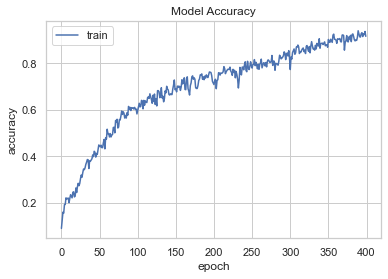

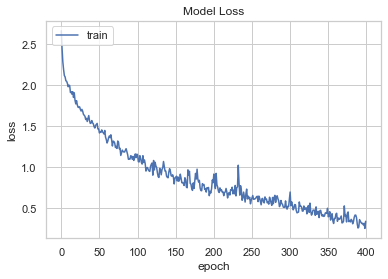

In [17]:
if TEST_MODEL is True:
    ##########################
    # # get model accuracy # #
    ##########################
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    ######################
    # # get model loss # #
    ######################
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

In [18]:
if TEST_MODEL is True:
    ##########################
    # # view model summary # #
    ##########################
    model.model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1, 256)            488448    
                                                                 
 dense_25 (Dense)            (None, 1, 256)            65792     
                                                                 
 dropout_20 (Dropout)        (None, 1, 256)            0         
                                                                 
 batch_normalization_15 (Bat  (None, 1, 256)           1024      
 chNormalization)                                                
                                                                 
 lstm_21 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dense_26 (Dense)            (None, 1, 128)            16512     
                                                      

#### MODEL TESTING
- Get Model Accuracy on the Test Dataset
- Generate Confusion Matrix
- Generate ROC Curves
- Save the Model if Appropriate

In [19]:
if TEST_MODEL is True:
    y_pred = model.predict_proba(X_test)

    # evaluate predictions
    acc = accuracy_score(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    print("Testing accuracy: %.3f%%" % (acc*100))

Testing accuracy: 83.750%


##### Confusion Matrix

240 is the number of test value in kfold_val / train_test_split


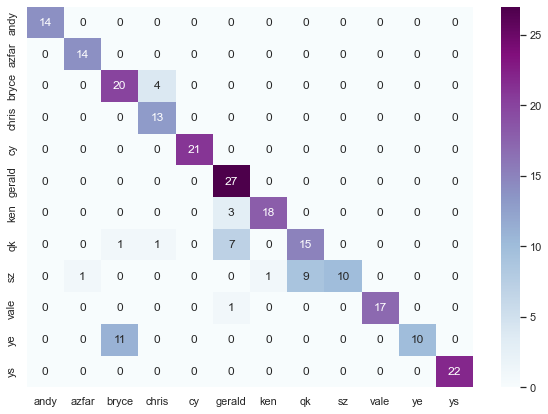

In [20]:
if TEST_MODEL is True and CON_MATRIX is True:
    # confusion matrix
    print(str(len(y_pred)) + " is the number of test value in kfold_val / train_test_split")
    cm = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    df_cm = pd.DataFrame(cm, index = [i for i in np.unique(lb.inverse_transform(y_test))],
                         columns = [i for i in np.unique(lb.inverse_transform(y_test))])

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="BuPu")

##### ROC Curve (Individual)

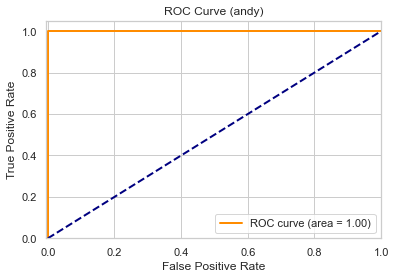

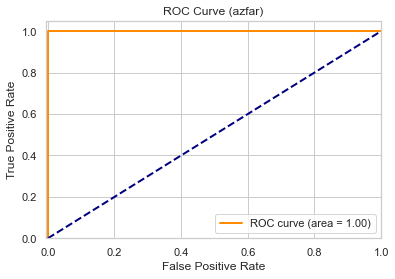

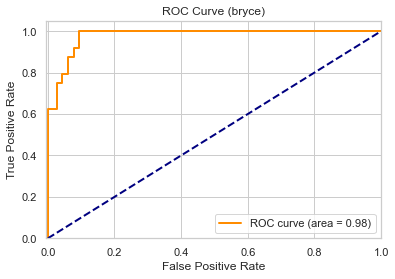

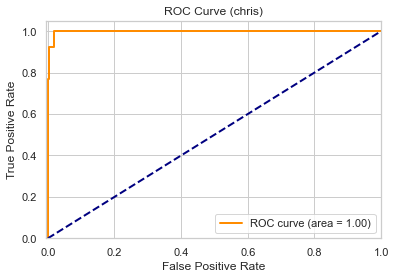

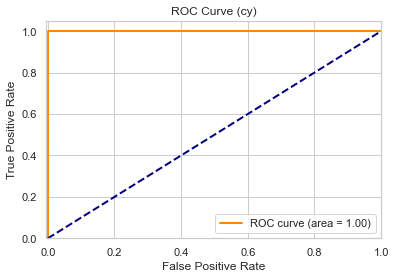

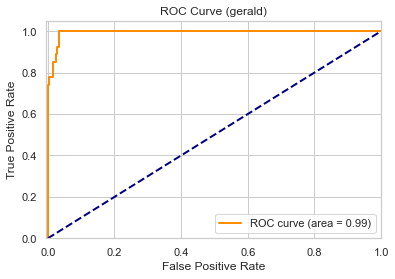

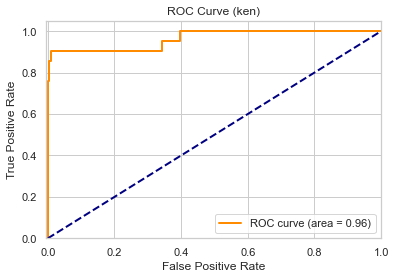

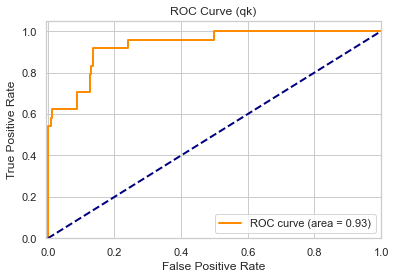

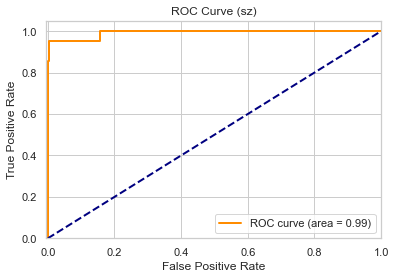

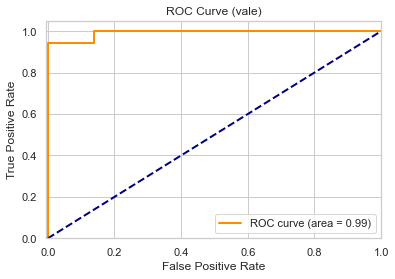

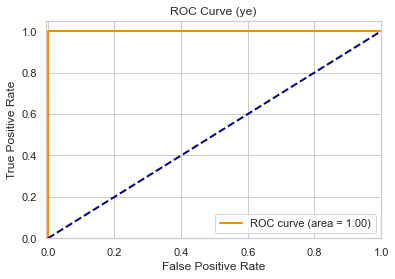

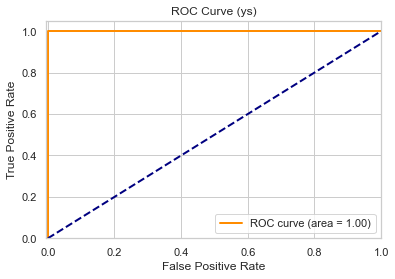

In [21]:
if TEST_MODEL is True and ROC_GRAPH is True: # compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        plt.figure()
        lw = 2
        plt.plot(
            fpr[i],
            tpr[i],
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc[i],
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([-0.005, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (" + str(lb.classes_[i]) + ")")
        plt.legend(loc="lower right")
        plt.show()

##### ROC Curve (Multiclass)

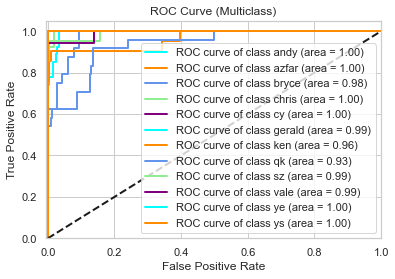

In [22]:
if TEST_MODEL is True and ROC_GRAPH is True:
    # compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # first aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    # plt.figure()
    # plt.plot(
    #     fpr["micro"],
    #     tpr["micro"],
    #     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    #     color="deeppink",
    #     linestyle=":",
    #     linewidth=4,
    # )

    # plt.plot(
    #     fpr["macro"],
    #     tpr["macro"],
    #     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    #     color="navy",
    #     linestyle=":",
    #     linewidth=4,
    # )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(lb.classes_[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multiclass)")
    plt.legend(loc="lower right")
    plt.show()

##### ROC Curve (Average)

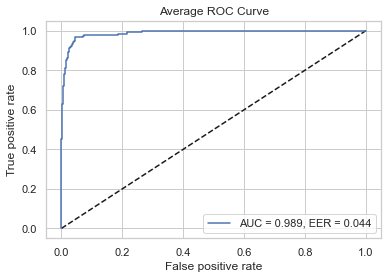

In [23]:
if TEST_MODEL is True and ROC_GRAPH is True:
    fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

    # calculate equal-error-rate
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='best')
    plt.show()

#### FIT AND SAVE MODEL
- Fitting of model
- Get Accuracy and Loss of Mdoel
- Saving Model

In [24]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)

df.head()
dataset = df.values

# divide data into features X and target (classes) Y
# convert target Y to labelbinarizer Y for model
X, Y, lb, class_list = prepare_dataset(df)

# reshaping the dataset to include LSTM Timesteps
X = reshape_dataset(X, TIMESTEPS)
n_classes = Y.shape[1]

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

LabelBinarizer is able to decipher: 
['andy' 'azfar' 'bryce' 'chris' 'cy' 'gerald' 'ken' 'qk' 'sz' 'vale' 'ye'
 'ys']


X | Features | Dataset Shape: (1200, 220)
Y | Classes  | Dataset Shape: (1200, 12)
There are a total of 12 classes.
Epoch 1/400
120/120 [==============================] - 6s 9ms/step - loss: 2.5668 - accuracy: 0.0858
Epoch 2/400
120/120 [==============================] - 1s 9ms/step - loss: 2.4329 - accuracy: 0.1150
Epoch 3/400
120/120 [==============================] - 1s 9ms/step - loss: 2.2743 - accuracy: 0.1558
Epoch 4/400
120/120 [==============================] - 1s 8ms/step - loss: 2.1708 - accuracy: 0.1467
Epoch 5/400
120/120 [==============================] - 1s 8ms/step - loss: 2.1387 - accuracy: 0.1475
Epoch 6/400
120/120 [==============================] - 1s 9ms/step - loss: 2.0880 - accuracy: 0.1692
Epoch 7/400
120/120 [==============================] - 1s 8ms/step - loss: 2.0357 - accuracy: 0.1817
Epoch 8/400
120/120 [==============================] - 1s

120/120 [==============================] - 1s 10ms/step - loss: 1.0790 - accuracy: 0.6117
Epoch 79/400
120/120 [==============================] - 1s 10ms/step - loss: 1.1314 - accuracy: 0.5833
Epoch 80/400
120/120 [==============================] - 1s 11ms/step - loss: 1.0548 - accuracy: 0.6308
Epoch 81/400
120/120 [==============================] - 1s 10ms/step - loss: 1.0579 - accuracy: 0.6275
Epoch 82/400
120/120 [==============================] - 1s 10ms/step - loss: 1.1153 - accuracy: 0.6117
Epoch 83/400
120/120 [==============================] - 1s 10ms/step - loss: 1.0623 - accuracy: 0.6142
Epoch 84/400
120/120 [==============================] - 1s 10ms/step - loss: 1.0748 - accuracy: 0.6100
Epoch 85/400
120/120 [==============================] - 1s 10ms/step - loss: 1.1451 - accuracy: 0.5925
Epoch 86/400
120/120 [==============================] - 1s 10ms/step - loss: 1.0981 - accuracy: 0.6017
Epoch 87/400
120/120 [==============================] - 1s 10ms/step - loss: 1.0101 - 

120/120 [==============================] - 1s 10ms/step - loss: 0.7132 - accuracy: 0.7742
Epoch 158/400
120/120 [==============================] - 1s 10ms/step - loss: 0.7054 - accuracy: 0.7617
Epoch 159/400
120/120 [==============================] - 1s 10ms/step - loss: 0.6637 - accuracy: 0.7725
Epoch 160/400
120/120 [==============================] - 1s 10ms/step - loss: 0.6360 - accuracy: 0.7867
Epoch 161/400
120/120 [==============================] - 1s 10ms/step - loss: 0.6656 - accuracy: 0.7758
Epoch 162/400
120/120 [==============================] - 1s 9ms/step - loss: 0.6685 - accuracy: 0.7767
Epoch 163/400
120/120 [==============================] - 1s 10ms/step - loss: 0.6338 - accuracy: 0.7908
Epoch 164/400
120/120 [==============================] - 1s 10ms/step - loss: 0.6591 - accuracy: 0.7917
Epoch 165/400
120/120 [==============================] - 1s 9ms/step - loss: 0.6907 - accuracy: 0.7817
Epoch 166/400
120/120 [==============================] - 1s 9ms/step - loss: 0.7

120/120 [==============================] - 1s 9ms/step - loss: 0.6787 - accuracy: 0.8117
Epoch 237/400
120/120 [==============================] - 1s 9ms/step - loss: 0.5078 - accuracy: 0.8558
Epoch 238/400
120/120 [==============================] - 1s 10ms/step - loss: 0.4359 - accuracy: 0.8742
Epoch 239/400
120/120 [==============================] - 1s 9ms/step - loss: 0.4133 - accuracy: 0.8867
Epoch 240/400
120/120 [==============================] - 1s 9ms/step - loss: 0.4520 - accuracy: 0.8800
Epoch 241/400
120/120 [==============================] - 1s 9ms/step - loss: 0.4099 - accuracy: 0.8892
Epoch 242/400
120/120 [==============================] - 1s 9ms/step - loss: 0.3906 - accuracy: 0.9000
Epoch 243/400
120/120 [==============================] - 1s 9ms/step - loss: 0.4070 - accuracy: 0.8900
Epoch 244/400
120/120 [==============================] - 1s 9ms/step - loss: 0.3803 - accuracy: 0.9025
Epoch 245/400
120/120 [==============================] - 1s 9ms/step - loss: 0.3935 - 

120/120 [==============================] - 1s 9ms/step - loss: 0.3380 - accuracy: 0.9208
Epoch 316/400
120/120 [==============================] - 1s 9ms/step - loss: 0.3520 - accuracy: 0.9117
Epoch 317/400
120/120 [==============================] - 1s 9ms/step - loss: 0.3851 - accuracy: 0.9058
Epoch 318/400
120/120 [==============================] - 1s 9ms/step - loss: 0.3307 - accuracy: 0.9225
Epoch 319/400
120/120 [==============================] - 1s 9ms/step - loss: 0.2900 - accuracy: 0.9258
Epoch 320/400
120/120 [==============================] - 1s 9ms/step - loss: 0.3035 - accuracy: 0.9258
Epoch 321/400
120/120 [==============================] - 1s 9ms/step - loss: 0.3263 - accuracy: 0.9200
Epoch 322/400
120/120 [==============================] - 1s 9ms/step - loss: 0.3426 - accuracy: 0.9208
Epoch 323/400
120/120 [==============================] - 1s 9ms/step - loss: 0.3014 - accuracy: 0.9217
Epoch 324/400
120/120 [==============================] - 1s 9ms/step - loss: 0.3055 - a

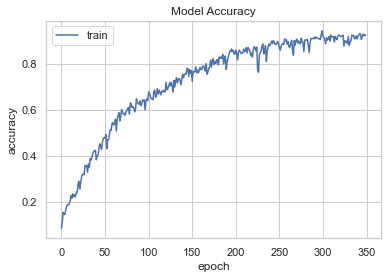

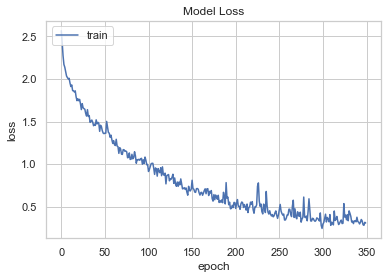

In [25]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### SAVE MODEL

In [26]:
##################
# # save model # #
##################
model.model.save(MODEL_PATH)

# LIVE TESTING
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [27]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [28]:
# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()

,Subject,Password,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T7-RF|VAR,T7-NG|VAR,T7-I|SD,T7-PF|SD,T7-RF|SD,T7-NG|SD,T8-I|0+7,T8-PF|0+7,T8-RF|0+7,T8-NG|0+7
0,andy,Co5mical,0.073992,0.003000,0.076992,0.094482,0.168474,0.091483,0.045362,0.136844,...,0.002609,0.001499,0.042155,0.029788,0.051080,0.038712,0.499024,0.573016,0.566388,0.640380
1,andy,Co5mical,0.100974,0.012187,0.113161,0.101644,0.202618,0.089456,0.033577,0.123034,...,0.004042,0.005144,0.048238,0.056383,0.063579,0.071723,0.518507,0.619481,0.597307,0.698281
2,andy,Co5mical,0.089725,0.045267,0.134991,0.167849,0.257574,0.122583,0.005957,0.128540,...,0.009055,0.005173,0.087968,0.064734,0.095156,0.071922,0.504553,0.594277,0.596016,0.685741
3,andy,Co5mical,0.067997,0.054379,0.122376,0.144052,0.212049,0.089673,0.000993,0.090666,...,0.007376,0.004978,0.081239,0.065912,0.085884,0.070557,0.477528,0.545525,0.563112,0.631109
4,andy,Co5mical,0.102257,0.003956,0.106213,0.089189,0.191446,0.085233,0.045437,0.130670,...,0.002313,0.003616,0.024290,0.036328,0.048092,0.060130,0.470455,0.572712,0.537894,0.640151


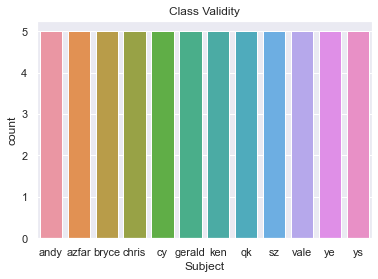

In [29]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [30]:
pred_dataset = pred_df.values
actual_np = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

print(class_list)
Y = np.asarray(class_list)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

['andy', 'azfar', 'bryce', 'chris', 'cy', 'gerald', 'ken', 'qk', 'sz', 'vale', 'ye', 'ys']


In [31]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

match_list = []

for _ in range(actual_np.size):
    if pred[_] == actual_np[_]:
        match_list.append("match")
    else:
        match_list.append("nope")

match_count = match_list.count("match")
total_count = len(match_list)

match_header = str(match_count) + "/" + str(total_count) + " (" + str(match_count/total_count*100)+ "%)"
match_np = np.array(match_list)

exported_output = np.column_stack((actual_np, pred))
exported_output = np.column_stack((exported_output, acc))
exported_output = np.column_stack((exported_output, match_np))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=exported_output, index=None, columns=['Actual', 'Prediction', 'Accuracy', match_header])
# print(df)
df.to_csv(RESULT_PATH)

print("Accuracy of the Model is: " + str(match_header))

Accuracy of the Model is: 59/60 (98.33333333333333%)


In [32]:
# print elapsed time
elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 01:00:20
